### Group similar motivations

We are going to regrabbed the motivations from the AI


In [1]:
# CELL 2
import os
import json
from datetime import datetime
import pytz

promt_file = 'prompt_no_guidance.txt'

# Define the prompt for each individual request
def prompt_formatted() -> str:    
    # Read the first file and set a string variable
    with open(promt_file, 'r') as file:
        prompt = file.read()
        
    with open('prompt_issues.md', 'r') as file:
        issues = file.read()

    with open('prompt_fact_sheet.md', 'r') as file:
        fact_sheet = file.read()

    prompt = prompt.replace('|issues|', issues)
    # prompt = prompt.replace('|guidance_note|', guidance_note)
    prompt = prompt.replace('|fact_sheet|', fact_sheet)    

    return prompt

def get_submission(submission_text: str, submission_author: str):
    prompt = ""
    prompt += "\n\n***************************************** SUBMISSION START *****************************************\n\n"

    prompt += f"Submission from: {submission_author}\n\n"
    
    prompt += submission_text

    prompt += "\n\n***************************************** SUBMISSION END *****************************************\n\n"
    return prompt

def get_function():
    with open('function_motivations.json', 'r') as f:
        function = json.load(f)
    return function

def get_file_path(doc_id, folder_path = './data/files'):    
    for file_name in os.listdir(folder_path):
        if file_name.startswith(doc_id):
            return os.path.join(folder_path, file_name)

with open('./data/step1/list.json', 'r') as f:
    list = json.load(f)

md_file_location = './data/files'

file_counter = 0
jsonl_file = f"./data/cleaning/toProcess/jsonl_{file_counter}.jsonl"

skipped_files = []

# Make cleaning directories
os.makedirs('./data/cleaning', exist_ok=True)
os.makedirs('./data/cleaning/toProcess', exist_ok=True)
os.makedirs('./data/cleaning/output', exist_ok=True)

prompt = prompt_formatted()

# This loop takes each submission and adds it to the jsonl file in a format that can be used by the OpenAI API
for i in list["data"]:
    if i["metadata"]["removed"] == "Y":
        skipped_files.append(i["uniqueId"])
        continue
    try:
        md_file_path = get_file_path(i.get("uniqueId"))       
        with open(md_file_path, 'r') as file:
            submission = file.read()                
        sub_author = i["submitter"]
        submission_formatted = get_submission(submission, sub_author)
        function = get_function()

        ldata = { "custom_id": i["uniqueId"], "method": "POST", "url": "/v1/chat/completions", "body": {"model": "gpt-4o-2024-05-13", "messages": [{"role": "system", "content": prompt},{"role": "user", "content": submission_formatted}], "max_tokens": 4096, "temperature": 1e-9, "frequency_penalty": 0, "presence_penalty": 0, "top_p": 0, "tools":[function], "tool_choice": { "type": "function", "function": { "name": "submission_eval" } }}}        
        
        if os.path.exists(jsonl_file) and os.path.getsize(jsonl_file) >= 85 * 1024 * 1024:  # 
            file_counter += 1
            jsonl_file = f"./data/cleaning/toProcess/jsonl_{file_counter}.jsonl"
        
        i["metadata"]["step_1"]["redo_motivation"] = {"batch_file": f'jsonl_{file_counter}.jsonl'}
        
        with open(jsonl_file, 'a') as f:
            json.dump(ldata, f)
            f.write('\n')

    except Exception as e:
        print(e)
        continue

local_timezone = pytz.timezone('Australia/Sydney')
current_time = datetime.now(local_timezone).strftime("%Y-%m-%d %H:%M:%S %Z")

list["metadata"]["step_1"]["redo_motivations"] = {
    "fn": get_function(),    
    "time": current_time
}

with open('./data/step1/list.json', 'w') as f:
    json.dump(list, f)

In [3]:
# CELL 3
from openai import OpenAI
import os
from datetime import datetime
import pytz

client = OpenAI(api_key=os.getenv('OPENAI_KEY'), max_retries=3)

jsonl_dir = './data/cleaning/toProcess'

jsonl_files = [f for f in os.listdir(jsonl_dir) if os.path.isfile(os.path.join(jsonl_dir, f)) and f.endswith('.jsonl')]

file_ids = []

for file in jsonl_files:
    file_object = client.files.create(
        file=open(f"{jsonl_dir}/{file}", "rb"),
        purpose="batch"
    )
    file_ids.append(file_object.id)

with open('./data/step1/list.json', 'r') as f:
    list = json.load(f)

local_timezone = pytz.timezone('Australia/Sydney')
current_time = datetime.now(local_timezone).strftime("%Y-%m-%d %H:%M:%S %Z")

list["metadata"]["step_1"]["redo_motivations"]["file_upload"] = {
            "timestamp": current_time,
            "file_ids": file_ids,
        }

with open('./data/step1/list.json', 'w') as f:
    json.dump(list, f)

In [4]:
# We have now uploaded all the files and have their IDs, lets create a batch job for each
batch_ids = []

with open('./data/step1/list.json', 'r') as f:
    list = json.load(f)

file_ids = list["metadata"]["step_1"]["redo_motivations"]["file_upload"]["file_ids"]

for file_id in file_ids:
    job = client.batches.create(
            input_file_id=file_id,
            endpoint="/v1/chat/completions",
            completion_window="24h"
          )
    batch_ids.append(job.id)

local_timezone = pytz.timezone('Australia/Sydney')
current_time = datetime.now(local_timezone).strftime("%Y-%m-%d %H:%M:%S %Z")

list["metadata"]["step_1"]["redo_motivations"]["batch_creation"] = {
            "timestamp": current_time,
            "batch_ids": batch_ids,
        }

with open('./data/step1/list.json', 'w') as f:
    json.dump(list, f)

In [18]:
with open('./data/step1/list.json', 'r') as f:
    list = json.load(f)

desired_batch_ids = list["metadata"]["step_1"]["redo_motivations"]["batch_creation"]["batch_ids"]

batch_jobs = client.batches.list()

for batch in batch_jobs.data:
    if batch.id in desired_batch_ids:
        print(batch.id, batch.status, batch.request_counts)

batch_ggV1ywntdgnHJMP9vLMj1IG8 completed BatchRequestCounts(completed=2129, failed=2, total=2131)
batch_3GFD0oI80DBFZ2vqUWDneO7T completed BatchRequestCounts(completed=133, failed=0, total=133)


In [19]:

batch_jobs = client.batches.list()

with open('./data/step1/list.json', 'r') as f:
    list = json.load(f)

# we only want to download the batch jobs that were set up in cell 11
desired_batch_ids = list["metadata"]["step_1"]["redo_motivations"]["batch_creation"]["batch_ids"]

success_count = 0
error_count = 0

created_time = None
completion_time = None

for batch in batch_jobs.data:
    if batch.id in desired_batch_ids:
        # Gets the first created batch time
        if not created_time or batch.created_at < created_time:
            created_time = batch.created_at
        # Gets the lasted completed batch time
        if not completion_time or batch.completed_at > completion_time:
            completion_time = batch.completed_at
        if batch.output_file_id:
            success_count += batch.request_counts.total - batch.request_counts.failed
            output_file = batch.output_file_id
            content = client.files.content(output_file)
            jsonl_file_path = f'./data/cleaning/output/{output_file}.jsonl'
            content.write_to_file(jsonl_file_path)
        # Handle error files
        if batch.error_file_id:
            error_count += batch.request_counts.failed
            err_file = batch.error_file_id
            err_content = client.files.content(err_file)
            err_jsonl_file_path = f'./data/cleaning/output/err_{err_file}.jsonl'
            err_content.write_to_file(err_jsonl_file_path)

local_timezone = pytz.timezone('Australia/Sydney')
current_time = datetime.now(local_timezone).strftime("%Y-%m-%d %H:%M:%S %Z")

time_difference = completion_time - created_time

list["metadata"]["step_1"]["redo_motivations"]["batch_creation"]["download_timestamp"] = current_time
list["metadata"]["step_1"]["redo_motivations"]["batch_creation"]["completetion_duration_seconds"] = time_difference
list["metadata"]["step_1"]["redo_motivations"]["batch_creation"]["success"] = success_count
list["metadata"]["step_1"]["redo_motivations"]["batch_creation"]["errors"] = error_count

with open('./data/step1/list.json', 'w') as f:
    json.dump(list, f)

In [21]:
import pandas as pd

# Parses the JSON from a function call, if there is an error in JSON parsing, recalls the LLM with the fix json function to get a valid json response.
def parse_JSON(json_str: str) -> dict:        
    try: 
        return json.loads(json_str)
    except Exception as e:              
        messages = [
      {
        'role': 'system',
        'content':
          'Assistant is a large language model designed to fix and return correct JSON objects.',
      },
      {
        'role': 'user',
        'content': f'ORIGINAL ERROR CONTAINING JSON OBJECT:\n\n{json_str}\n\nERROR MESSAGE: {e}',
      },
    ]
        
        tool_choices = [{
      'type': 'function',
      'function': {
        'name': 'fix_object',
        'description':
          'You will be given an incorrectly formed JSON Object and a error message. You must fix the incorrect JSON Object and return the valid JSON object.',
        'parameters': {
          'type': 'object',
          'properties': {
            'fixedJSON': {
              'type': 'string',
              'description': 'The reformated and error free JSON object. Return the JSON object only!',
            },
          },
          'required': ['fixedJSON'],
        },
      },
    }]                
        response = client.chat.completions.create(
                    model='gpt-4o-2024-05-13',
                    messages=messages,                    
                    max_tokens=4096,
                    temperature=0,
                    tools=tool_choices,
                    tool_choice={ 'type': 'function', 'function': { 'name': 'fix_object' } },        
                )        
                
        second_test_json = response.choices[0].message.tool_calls[0].function.arguments 
                  
        to_return = json.loads(second_test_json)
        return json.loads(to_return['fixedJSON'])

output_folder = './data/cleaning/output'

jsonl_files = [f for f in os.listdir(output_folder) if os.path.isfile(os.path.join(output_folder, f)) and f.endswith('.jsonl')]

# Load original JSON list
with open('./data/step1/list.json', 'r') as f:
    list_data = json.load(f)

prompt_tokens = 0
completion_tokens = 0
total_tokens = 0

# Load the JSONL files
for file in jsonl_files:    
    with open(f"{output_folder}/{file}", "r") as f:
        for line in f:
            item = json.loads(line)            
            item_key = item['custom_id']            
            # grab the matching item in our list            
            list_item = next((x for x in list_data["data"] if x['uniqueId'] == item_key), None)
            if list_item:
              if item["response"]["status_code"] != 200:                
                list_item["metadata"]["step_1"]["redo_motivation"]["error"] = item["response"]
                continue
              json_res = parse_JSON(item['response']['body']['choices'][0]['message']['tool_calls'][0]['function']['arguments'])
              list_item["step_1"]["new_motivations"] = json_res
              list_item["metadata"]["step_1"]["redo_motivation"]["system_fingerprint"] = item['response']['body']['system_fingerprint']
              list_item["metadata"]["step_1"]["redo_motivation"]["batch_id"] = item['id']
              prompt_tokens += item['response']['body']["usage"]["prompt_tokens"]
              completion_tokens += item['response']['body']["usage"]["completion_tokens"]
              total_tokens += item['response']['body']["usage"]["total_tokens"]

local_timezone = pytz.timezone('Australia/Sydney')
current_time = datetime.now(local_timezone).strftime("%Y-%m-%d %H:%M:%S %Z")

list_data["metadata"]["step_1"]["redo_motivations"]["batch_processed"] = {"timestamp": current_time}
list_data["metadata"]["step_1"]["redo_motivations"]["usage"] = {"prompt_tokens": prompt_tokens, "completion_tokens": completion_tokens, "total_tokens": total_tokens}

# Save the updated list back to the json file
with open('./data/step1/list.json', 'w') as f:
    json.dump(list_data, f)

# Export the list to an Excel file for review
# Convert JSON to DataFrame
df = pd.json_normalize(list_data["data"])

# Save DataFrame to Excel
df.to_excel('./data/cleaning/step1.xlsx', index=False)

## Lets go reclustering!

#### This first cell purely updates all motivations to lowercase strings & saves a list of all motivations


In [32]:
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
import json

# Data to process
with open('./data/step1/list.json', 'r') as f:
    list = json.load(f)

all_motivations = []

for item in tqdm(list['data']):
    if "step_1" not in item or item['step_1'] is None or "new_motivations" not in item['step_1']:        
        continue
    try:
        motivations = item['step_1']['new_motivations']['motivations'] if 'motivations' in item['step_1']['new_motivations'] else []
        if not motivations:            
            continue
        if len(motivations) == 0:            
            continue
        lower_case_motivations = []
        for motivation in motivations:
            motivation['label'] = motivation['label'].lower()
            lower_case_motivations.append(motivation)
        item['step_1']['new_motivations']['motivations'] = lower_case_motivations
        all_motivations.extend(lower_case_motivations)
        if 'updated_motivations' in item['metadata']['step_1']:
            item['metadata']['step_1']['updated_motivations']['new_motivations'] = {'original': motivations}
        else:
            item['metadata']['step_1']['updated_motivations'] = {'new_motivations': {'original': motivations}}
        continue
    
    except Exception as e:
        print(f"Error occurred: {str(e)}")        
        continue

with open('./data/step1/list.json', 'w') as f:
    json.dump(list, f)

with open('data_cleaning_motivations_new.json', 'w') as file:
    json.dump(all_motivations, file)

  0%|          | 0/2267 [00:00<?, ?it/s]

18110
19154
21073
21521
21685
22097
22903
22964
23342
25663
26546
27466
27586
29510
30126
32541
p2
23899
25555
25965
18969
32589
21875
32201
31682
13919
21276
29918
27749
e779
16657
22448


### We are going to cluster similar motivations


In [7]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from ai_client import get_vector
import os
import warnings

In [35]:
import json

# Load the JSON file
with open('data_cleaning_motivations_new.json', 'r') as file:
    data = json.load(file)

# Initialize an empty list
topics_all = data

print(f"Total motivations: {len(topics_all)}")

# Only need unique items
topics = (set([value["label"] for value in topics_all if value]))
print(f"Unique motivations: {len(topics)}")

Total motivations: 6460
Unique motivations: 1946


## Get embeddings for all unique list items

This is done in parallel to speed up processing of large lists


In [8]:
import json
from concurrent.futures import ThreadPoolExecutor

# Load the JSON file
with open('data_cleaning_motivations_new.json', 'r') as file:
    data = json.load(file)

def get_embedding(string, main_pbar):    
    vector = get_vector(string)
    main_pbar.update(1)
    return vector

def load_saved_embeddings(file_path):
    if os.path.exists(file_path):
        return np.load(file_path, allow_pickle=True).item()
    return None

# Generate embeddings for all unique topics
def generate_embeddings_parallel(data, file_path='data_cleaning_motivations_new_embeddings.npy'):
    # Check if embeddings are already saved
    saved_embeddings = load_saved_embeddings(file_path)
    if saved_embeddings is not None:
        print("Embeddings loaded from file.")
        return saved_embeddings
    
    embeddings_dict = {}
    with tqdm(total=len(data), desc="Overall Progress") as main_pbar:
        with ThreadPoolExecutor(max_workers=5) as executor:
            futures = {executor.submit(get_embedding, item['explanation'], main_pbar): item['label'] for item in data}
            for future in futures:
                label = futures[future]
                embeddings_dict[label] = future.result()
    
    np.save(file_path, embeddings_dict)
    return embeddings_dict

embeddings = generate_embeddings_parallel(data)
topics = [item['label'] for item in data]

Embeddings loaded from file.


In [9]:
embeddings_file_path = 'data_cleaning_motivations_new_embeddings.npy'
embeddings_dict = np.load(embeddings_file_path, allow_pickle=True).item()
labels, embeddings = zip(*embeddings_dict.items())
embeddings = np.array(embeddings)

## Old approach to determine optimal cluster size and algorithm


### Determine the optimal number of clusters using the Elbow method

The weights for each metric are somewhat arbitrary but were informed by their
general strengths and common usage in clustering evaluation:

**Kneedle Algorithm (0.3):**

- Strengths: The Kneedle algorithm is effective at detecting the "elbow" in the
  inertia plot, which indicates a balance between the number of clusters and
  within-cluster variance.
- Weaknesses: It relies solely on the inertia metric, which can sometimes be
  misleading, especially with high-dimensional data or when the data does not
  form clear clusters.
- Rationale: Given its reliance on inertia, a moderate weight is assigned to
  account for its utility without overemphasizing it.

**Silhouette Score (0.5):**

- Strengths: The silhouette score is a widely used and robust metric for
  evaluating clustering quality. It considers both cohesion (how close points in
  a cluster are) and separation (how far apart clusters are).
- Weaknesses: The silhouette score can be sensitive to the shape of clusters and
  might not always favor the correct number of clusters in complex datasets.
- Rationale: Due to its robustness and comprehensive evaluation of clustering
  quality, it is given the highest weight.

**Davies-Bouldin Index (0.2):**

- Strengths: The Davies-Bouldin index measures the average similarity ratio of
  each cluster with the cluster that is most similar to it, providing a good
  indicator of cluster distinctness.
- Weaknesses: It can sometimes be less intuitive and might not always correlate
  with visual assessments of clustering quality.
- Rationale: While useful, it is given a lower weight compared to the silhouette
  score to avoid over-reliance on a single metric.


In [ ]:
range_max = 250  # Adjust the range based on expected number of clusters

# Custom wieghts to assist in selecting the optimal k
weights = {
    'kneedle': 0.3,  
    'silhouette': 0.5,
    'davies_bouldin': 0.2
}

# Calculate inertia for a range of k
inertias = []
k_range = range(1, range_max) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(embeddings)
    inertias.append(kmeans.inertia_)

# Automatically detect the elbow point using the Kneedle algorithm
kneedle = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

# Define the clustering algorithm with a range of k
kmeans = KMeans(random_state=0, n_init=10)
param_grid = {'n_clusters': Integer(2, range_max - 1)}

# Use BayesSearchCV for optimization
bayes_search = BayesSearchCV(kmeans, param_grid, n_iter=50, cv=StratifiedKFold(n_splits=5))
bayes_search.fit(embeddings, [0]*len(embeddings))  # Dummy labels for unsupervised learning

optimal_k_bayes = bayes_search.best_params_['n_clusters']

# Validate with silhouette scores and Davies-Bouldin index
silhouette_scores = []
davies_scores = []
for k in range(2, range_max):  # Start from 2 since silhouette score is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(embeddings)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(embeddings, labels))
    davies_scores.append(davies_bouldin_score(embeddings, labels))

# Plot the inertia values for kneedle
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, range_max), silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.show()

# Plot Davies-Bouldin scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, range_max), davies_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Different k')
plt.show()

# Select the optimal k based on the combination of metrics
optimal_k_silhouette = np.argmax(silhouette_scores) + 2  # +2 because the range starts from 2
optimal_k_davies = np.argmin(davies_scores) + 2  # +2 because the range starts from 2

print(f"Optimal number of clusters detected by Kneedle: {optimal_k}")
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_silhouette}")
print(f"Optimal number of clusters based on Davies-Bouldin Index: {optimal_k_davies}")
print(f"Optimal number of clusters based on Bayesian optimization: {optimal_k_bayes}")

# Final decision on optimal_k
# You can choose to average the results or select based on additional criteria
# optimal_k = round((
#     weights['kneedle'] * optimal_k + 
#     weights['silhouette'] * optimal_k_silhouette + 
#     weights['davies_bouldin'] * optimal_k_davies
# ) / sum(weights.values()))

optimal_k = optimal_k_bayes

print(f"Final optimal number of clusters: {optimal_k}")

### Evaluate the clustering results

Presents the metrics for different clustering methods. To interpret the outputs
from the Silhouette Coefficient, Calinski-Harabasz Index, and Davies-Bouldin
Index, here's a guide:

1. Silhouette Coefficient:

   - The Silhouette Coefficient measures how well each data point fits into its
     assigned cluster compared to other clusters.
   - It ranges from -1 to 1, where:
     - A value close to 1 indicates that the data point is well-matched to its
       own cluster and poorly-matched to neighboring clusters.
     - A value close to 0 indicates that the data point is on or very close to
       the decision boundary between two neighboring clusters.
     - A value close to -1 indicates that the data point might have been
       assigned to the wrong cluster.
   - A higher Silhouette Coefficient (closer to 1) suggests better clustering
     results.

2. Calinski-Harabasz Index:

   - The Calinski-Harabasz Index, also known as the Variance Ratio Criterion,
     measures the ratio of between-cluster dispersion to within-cluster
     dispersion.
   - It is calculated as (SS_between / SS_within) \* ((n_samples - n_clusters) /
     (n_clusters - 1)), where:
     - SS_between is the sum of squared distances between cluster centers and
       the overall mean.
     - SS_within is the sum of squared distances between data points and their
       respective cluster centers.
     - n_samples is the total number of data points.
     - n_clusters is the number of clusters.
   - A higher Calinski-Harabasz Index indicates better-defined and
     well-separated clusters.

3. Davies-Bouldin Index:
   - The Davies-Bouldin Index measures the average similarity between clusters,
     where the similarity is defined as the ratio of within-cluster distances to
     between-cluster distances.
   - It is calculated as the average of the maximum similarity between each
     cluster and its most similar cluster.
   - A lower Davies-Bouldin Index indicates better clustering results, as it
     suggests that the clusters are well-separated and compact.

When evaluating the clustering performance using these metrics, you should
consider the following:

1. Compare the metric values across different clustering algorithms or parameter
   settings to determine which one performs better.

2. Look for higher Silhouette Coefficient values (closer to 1), higher
   Calinski-Harabasz Index values, and lower Davies-Bouldin Index values, as
   they indicate better clustering results.

3. Keep in mind that these metrics provide a quantitative assessment of the
   clustering quality, but they should be interpreted in the context of your
   specific problem and domain knowledge.

4. It's important to note that these metrics have their own assumptions and
   limitations. For example, the Silhouette Coefficient assumes that the
   clusters are convex and may not perform well with non-convex clusters. The
   Calinski-Harabasz Index and Davies-Bouldin Index are affected by the scale of
   the data and may not be suitable for comparing clusterings with different
   numbers of clusters.

5. Use these metrics as a guide, but also consider other factors such as the
   interpretability and usefulness of the clusters in your specific application.

Here's an example of how you can interpret the metric values:

```
K-means Silhouette Coefficient: 0.6
K-means Calinski-Harabasz Index: 100.0
K-means Davies-Bouldin Index: 1.2
```

In this case, the Silhouette Coefficient of 0.6 suggests a reasonable clustering
result, with data points being moderately well-matched to their own clusters.
The Calinski-Harabasz Index of 100.0 indicates well-separated clusters, and the
Davies-Bouldin Index of 1.2 suggests relatively compact clusters. These values
indicate a good overall clustering performance for the K-means algorithm.

### Use the best cluster algorithm for the following step


In [ ]:
# Custom estimator for DBSCAN to use with GridSearchCV
class DBSCANEstimator(BaseEstimator, ClusterMixin):
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, X, y=None):
        self.model = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.model.fit(X)
        self.labels_ = self.model.labels_
        return self

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

# Function to compute silhouette score, ignoring noise points (-1 labels)
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1

# Define the parameter grid for DBSCAN
param_grid = {
    'eps': np.arange(0.3, 1.0, 0.1),
    'min_samples': np.arange(3, 10, 1)
}

# Initialize the custom DBSCAN estimator
dbscan_estimator = DBSCANEstimator()

# Perform GridSearchCV for DBSCAN
grid_search = GridSearchCV(dbscan_estimator, param_grid, scoring=silhouette_scorer, cv=3)
grid_search.fit(embeddings)

# Best parameters for DBSCAN
best_params = grid_search.best_params_
print(f"Best parameters for DBSCAN: {best_params}")

# Best DBSCAN model
best_dbscan = grid_search.best_estimator_

# Fit the clustering algorithms
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10).fit(embeddings)
gmm = GaussianMixture(n_components=optimal_k, random_state=0).fit(embeddings)
agglomerative = AgglomerativeClustering(n_clusters=optimal_k).fit(embeddings)
spectral = SpectralClustering(n_clusters=optimal_k, affinity='nearest_neighbors').fit(embeddings)
kmedoids = KMedoids(n_clusters=optimal_k, random_state=0).fit(embeddings)

# Get the labels
kmeans_labels = kmeans.labels_
dbscan_labels = best_dbscan.fit_predict(embeddings)
gmm_labels = gmm.predict(embeddings)
agglomerative_labels = agglomerative.labels_
spectral_labels = spectral.labels_
kmedoids_labels = kmedoids.labels_

# Calculate the metrics
kmeans_silhouette = silhouette_score(embeddings, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(embeddings, kmeans_labels)
kmeans_davies = davies_bouldin_score(embeddings, kmeans_labels)

agglomerative_silhouette = silhouette_score(embeddings, agglomerative_labels)
agglomerative_calinski = calinski_harabasz_score(embeddings, agglomerative_labels)
agglomerative_davies = davies_bouldin_score(embeddings, agglomerative_labels)

spectral_silhouette = silhouette_score(embeddings, spectral_labels)
spectral_calinski = calinski_harabasz_score(embeddings, spectral_labels)
spectral_davies = davies_bouldin_score(embeddings, spectral_labels)

kmedoids_silhouette = silhouette_score(embeddings, kmedoids_labels)
kmedoids_calinski = calinski_harabasz_score(embeddings, kmedoids_labels)
kmedoids_davies = davies_bouldin_score(embeddings, kmedoids_labels)

# Calculate the metrics for DBSCAN, handle the case where DBSCAN fails
try:
    dbscan_silhouette = silhouette_score(embeddings, dbscan_labels)
    dbscan_calinski = calinski_harabasz_score(embeddings, dbscan_labels)
    dbscan_davies = davies_bouldin_score(embeddings, dbscan_labels)
except ValueError as e:
    print(f"Error occurred while evaluating DBSCAN: {str(e)}")
    dbscan_silhouette = None
    dbscan_calinski = None
    dbscan_davies = None
    print("DBSCAN failed to find meaningful clusters. Adjusting parameters or considering a different algorithm might help.")

gmm_silhouette = silhouette_score(embeddings, gmm_labels)
gmm_calinski = calinski_harabasz_score(embeddings, gmm_labels)
gmm_davies = davies_bouldin_score(embeddings, gmm_labels)

# Store the metrics in lists for plotting
silhouette_scores = [kmeans_silhouette, dbscan_silhouette, gmm_silhouette, agglomerative_silhouette, spectral_silhouette, kmedoids_silhouette]
calinski_scores = [kmeans_calinski, dbscan_calinski, gmm_calinski, agglomerative_calinski, spectral_calinski, kmedoids_calinski]
davies_scores = [kmeans_davies, dbscan_davies, gmm_davies, agglomerative_davies, spectral_davies, kmedoids_davies]

# Invert the Davies-Bouldin scores for visual consistency
davies_scores = [1/score if score is not None else None for score in davies_scores]

# Names of the clustering algorithms
algorithms = ['K-means', 'DBSCAN', 'GMM', 'Agglomerative', 'Spectral', 'KMedoids']

# Set up the bar width and positions
barWidth = 0.25
r1 = np.arange(len(silhouette_scores))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar plot
plt.figure(figsize=(10, 6))

plt.bar(r1, silhouette_scores, color='blue', width=barWidth, edgecolor='grey', label='Silhouette Coefficient')
plt.bar(r2, calinski_scores, color='red', width=barWidth, edgecolor='grey', label='Calinski-Harabasz Index')
plt.bar(r3, davies_scores, color='green', width=barWidth, edgecolor='grey', label='Davies-Bouldin Index (inverted)')

# Add the algorithm names to the x-axis
plt.xlabel('Clustering Algorithm', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(silhouette_scores))], algorithms)

# Add the title and the legend
plt.title('Clustering Performance Metrics')
plt.legend()

# Highlight the best values
max_silhouette = max(filter(None, silhouette_scores))
max_calinski = max(filter(None, calinski_scores))
max_davies = max(filter(None, davies_scores))

# Add a text label above the bars with the best values
for i in range(len(algorithms)):
    if silhouette_scores[i] == max_silhouette:
        plt.text(r1[i], silhouette_scores[i], f'Best', ha='center', color='black')
    if calinski_scores[i] == max_calinski:
        plt.text(r2[i], calinski_scores[i], f'Best', ha='center', color='black')
    if davies_scores[i] == max_davies:
        plt.text(r3[i], davies_scores[i], f'Best', ha='center', color='black')

# Show the plot
plt.show()

## New approach to determining best cluster number and algorithm


In [10]:
max_range = 500 # max number of clusters desired
number_iterations = 300

# Custom estimator for DBSCAN to use with GridSearchCV
class DBSCANEstimator(BaseEstimator, ClusterMixin):
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, X, y=None):
        self.model = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.model.fit(X)
        self.labels_ = self.model.labels_
        return self

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

# Function to compute silhouette score, ignoring noise points (-1 labels)
def silhouette_scorer(estimator, X, y=None):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1

# Create a custom scorer using make_scorer
silhouette_scorer_custom = make_scorer(silhouette_scorer, greater_is_better=True)

# Early stopping parameters
early_stopping_threshold = 0.001  # Minimum improvement to continue
early_stopping_patience = 10  # Number of iterations with no significant improvement

# Callback function for early stopping
class EarlyStoppingCallback:
    def __init__(self, early_stopping_threshold, early_stopping_patience):
        self.early_stopping_threshold = early_stopping_threshold
        self.early_stopping_patience = early_stopping_patience
        self.best_score = -np.inf
        self.no_improvement_count = 0

    def __call__(self, result):
        current_score = result.func_vals[-1]

        if current_score - self.best_score > self.early_stopping_threshold:
            self.best_score = current_score
            self.no_improvement_count = 0
        else:
            self.no_improvement_count += 1

        if self.no_improvement_count >= self.early_stopping_patience:
            raise StopIteration(f"Early stopping at iteration {len(result.func_vals)}")

# Use Bayesian optimization with early stopping for fine-tuning
def optimize_kmeans(embeddings):
    kmeans = KMeans(random_state=0, n_init=10)
    param_grid = {'n_clusters': Integer(2, max_range)}
    search = BayesSearchCV(kmeans, param_grid, n_iter=number_iterations, scoring=silhouette_scorer_custom, cv=StratifiedKFold(n_splits=5), random_state=0)
    early_stopping = EarlyStoppingCallback(early_stopping_threshold, early_stopping_patience)
    try:
        search.fit(embeddings, [0]*len(embeddings), callback=[early_stopping])
    except StopIteration as e:
        print(e)
    return search.best_estimator_, search.best_estimator_.labels_, search.best_params_['n_clusters']

def optimize_dbscan(embeddings):
    param_grid = {
        'eps': Real(0.3, 1.0),
        'min_samples': Integer(3, 10)
    }
    search = BayesSearchCV(DBSCANEstimator(), param_grid, n_iter=number_iterations, scoring=silhouette_scorer_custom, cv=StratifiedKFold(n_splits=5), random_state=0)
    early_stopping = EarlyStoppingCallback(early_stopping_threshold, early_stopping_patience)
    try:
        search.fit(embeddings, [0]*len(embeddings), callback=[early_stopping])
    except StopIteration as e:
        print(e)
    return search.best_estimator_, search.best_estimator_.labels_

def optimize_gmm(embeddings):
    gmm = GaussianMixture(random_state=0)
    param_grid = {'n_components': Integer(2, max_range)}  # Extended range
    search = BayesSearchCV(gmm, param_grid, n_iter=number_iterations, scoring=silhouette_scorer_custom, cv=StratifiedKFold(n_splits=5), random_state=0)
    early_stopping = EarlyStoppingCallback(early_stopping_threshold, early_stopping_patience)
    try:
        search.fit(embeddings, [0]*len(embeddings), callback=[early_stopping])
    except StopIteration as e:
        print(e)
    return search.best_estimator_, search.best_estimator_.predict(embeddings), search.best_params_['n_components']

def optimize_agglomerative(embeddings):
    agglomerative = AgglomerativeClustering()
    param_grid = {'n_clusters': Integer(2, max_range)}  # Extended range
    search = BayesSearchCV(agglomerative, param_grid, n_iter=number_iterations, scoring=silhouette_scorer_custom, cv=StratifiedKFold(n_splits=5), random_state=0)
    early_stopping = EarlyStoppingCallback(early_stopping_threshold, early_stopping_patience)
    try:
        search.fit(embeddings, [0]*len(embeddings), callback=[early_stopping])
    except StopIteration as e:
        print(e)
    return search.best_estimator_, search.best_estimator_.labels_, search.best_params_['n_clusters']

def optimize_spectral(embeddings):
    spectral = SpectralClustering(affinity='nearest_neighbors')
    param_grid = {'n_clusters': Integer(2, max_range)}  # Extended range
    search = BayesSearchCV(spectral, param_grid, n_iter=number_iterations, scoring=silhouette_scorer_custom, cv=StratifiedKFold(n_splits=5), random_state=0)
    early_stopping = EarlyStoppingCallback(early_stopping_threshold, early_stopping_patience)
    try:
        search.fit(embeddings, [0]*len(embeddings), callback=[early_stopping])
    except StopIteration as e:
        print(e)
    return search.best_estimator_, search.best_estimator_.labels_, search.best_params_['n_clusters']

def optimize_kmedoids(embeddings):
    kmedoids = KMedoids(random_state=0)
    param_grid = {'n_clusters': Integer(2, max_range)}  # Extended range
    search = BayesSearchCV(kmedoids, param_grid, n_iter=number_iterations, scoring=silhouette_scorer_custom, cv=StratifiedKFold(n_splits=5), random_state=0)
    early_stopping = EarlyStoppingCallback(early_stopping_threshold, early_stopping_patience)
    try:
        search.fit(embeddings, [0]*len(embeddings), callback=[early_stopping])
    except StopIteration as e:
        print(e)
    return search.best_estimator_, search.best_estimator_.labels_, search.best_params_['n_clusters']

# Optimize each algorithm
optimal_kmeans, kmeans_labels, kmeans_optimal_k = optimize_kmeans(embeddings)
optimal_dbscan, dbscan_labels = optimize_dbscan(embeddings)
optimal_gmm, gmm_labels, gmm_optimal_k = optimize_gmm(embeddings)
optimal_agglomerative, agglomerative_labels, agglomerative_optimal_k = optimize_agglomerative(embeddings)
optimal_spectral, spectral_labels, spectral_optimal_k = optimize_spectral(embeddings)
optimal_kmedoids, kmedoids_labels, kmedoids_optimal_k = optimize_kmedoids(embeddings)

# Calculate the metrics for each optimized algorithm
metrics = {
    'K-means': (kmeans_labels, optimal_kmeans, kmeans_optimal_k),
    'DBSCAN': (dbscan_labels, optimal_dbscan, None),  # DBSCAN does not have a fixed number of clusters
    'GMM': (gmm_labels, optimal_gmm, gmm_optimal_k),
    'Agglomerative': (agglomerative_labels, optimal_agglomerative, agglomerative_optimal_k),
    'Spectral': (spectral_labels, optimal_spectral, spectral_optimal_k),
    'KMedoids': (kmedoids_labels, optimal_kmedoids, kmedoids_optimal_k)
}

silhouette_scores = []
calinski_scores = []
davies_scores = []
algorithms = []
optimal_ks = []

for name, (labels, model, optimal_k) in metrics.items():
    if len(set(labels)) > 1:  # Ensure there is more than one cluster
        silhouette = silhouette_score(embeddings, labels)
        calinski = calinski_harabasz_score(embeddings, labels)
        davies = davies_bouldin_score(embeddings, labels)
    else:
        silhouette = calinski = davies = None

    silhouette_scores.append(silhouette)
    calinski_scores.append(calinski)
    davies_scores.append(1/davies if davies is not None else None)
    algorithms.append(name)
    optimal_ks.append(optimal_k)

# Set up the bar width and positions
barWidth = 0.25
r1 = np.arange(len(silhouette_scores))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar plot
plt.figure(figsize=(10, 6))

plt.bar(r1, silhouette_scores, color='blue', width=barWidth, edgecolor='grey', label='Silhouette Coefficient')
plt.bar(r2, calinski_scores, color='red', width=barWidth, edgecolor='grey', label='Calinski-Harabasz Index')
plt.bar(r3, davies_scores, color='green', width=barWidth, edgecolor='grey', label='Davies-Bouldin Index (inverted)')

# Add the algorithm names to the x-axis
plt.xlabel('Clustering Algorithm', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(silhouette_scores))], algorithms)

# Add the title and the legend
plt.title('Clustering Performance Metrics')
plt.legend()

# Highlight the best values
max_silhouette = max(filter(None, silhouette_scores))
max_calinski = max(filter(None, calinski_scores))
max_davies = max(filter(None, davies_scores))

# Add a text label above the bars with the best values
for i in range(len(algorithms)):
    if silhouette_scores[i] == max_silhouette:
        plt.text(r1[i], silhouette_scores[i], f'Best', ha='center', color='black')
    if calinski_scores[i] == max_calinski:
        plt.text(r2[i], calinski_scores[i], f'Best', ha='center', color='black')
    if davies_scores[i] == max_davies:
        plt.text(r3[i], davies_scores[i], f'Best', ha='center', color='black')

# Show the plot
plt.show()

# Determine the best algorithm based on the highest silhouette score
best_algorithm_index = np.argmax(silhouette_scores)
best_algorithm = algorithms[best_algorithm_index]
best_algorithm_labels = metrics[best_algorithm][0]
best_algorithm_optimal_k = optimal_ks[best_algorithm_index]

print(f"The best clustering algorithm is: {best_algorithm} with a silhouette score of {silhouette_scores[best_algorithm_index]}")
if best_algorithm_optimal_k is not None:
    print(f"The optimal number of clusters for {best_algorithm} is: {best_algorithm_optimal_k}")

AttributeError: 'list' object has no attribute 'fit_predict'

## From the above cell, set the best label value

It will be one of:

- kmeans_labels
- dbscan_labels
- gmm_labels


In [ ]:
best_labels = kmeans_labels
best_algorithm = 'KMedoids' # or anything else (as KMedoids is only value that changes code execution)

## Group and display the topics

This will output the list of clusters


In [ ]:
# Organize clustered topics
clustered_topics = [[] for _ in range(optimal_k)]
for topic, label in zip(topics, best_labels):
    clustered_topics[label].append(topic)

# Prepare the dictionary to save
clusters_dict = {}

if best_algorithm == 'KMedoids':
    # If the best algorithm is KMedoids, use the medoids directly as representatives
    for i, cluster in enumerate(clustered_topics):
        representative_topic = topics[kmedoids.medoid_indices_[i]]
        clusters_dict[representative_topic] = {
            "topics": cluster
        }
else:
    # For other algorithms, calculate the centroid and find the closest topic
    for i, cluster in enumerate(clustered_topics):
        # Get the embeddings for the current cluster
        cluster_embeddings = np.array([embeddings[topics.index(topic)] for topic in cluster])
        
        # Calculate the centroid of the cluster
        centroid = np.mean(cluster_embeddings, axis=0)
        
        # Calculate the distances from each embedding to the centroid
        distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)
        
        # Find the index of the representative topic (the one closest to the centroid)
        representative_idx = np.argmin(distances)
        
        # Add the representative topic and the full list of topics to the dictionary
        clusters_dict[f"{cluster[representative_idx]}"] = {
            "topics": cluster
        }

# Save to a JSON file
with open('data_cleaning_motivations_new_clusters.json', 'w') as json_file:
    json.dump(clusters_dict, json_file, indent=4)

print("Clusters have been saved to clusters.json")


## Visualise clusters

Not necessary but to visualise the results continue here


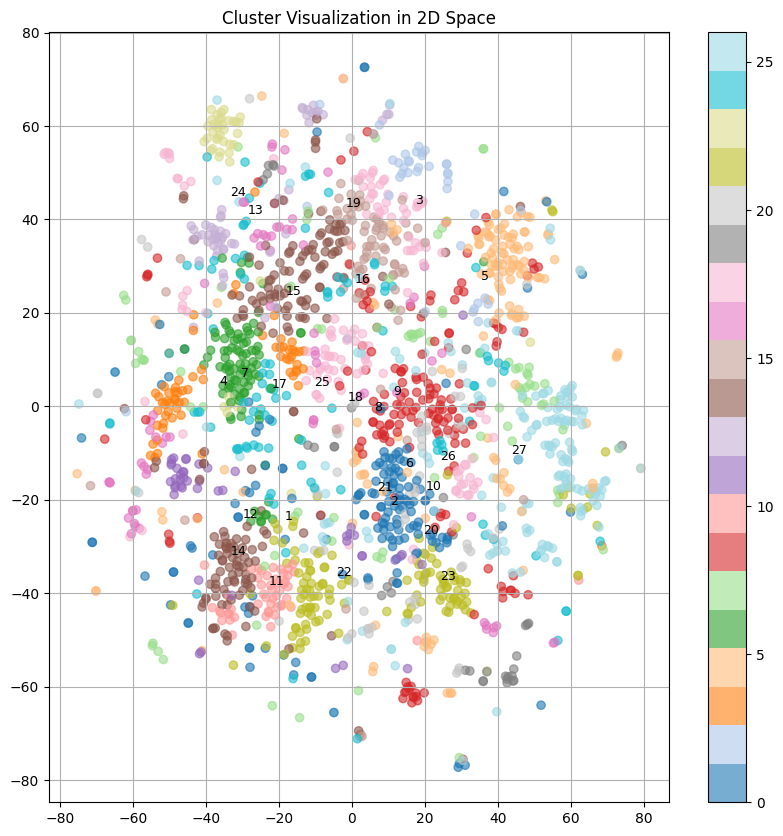

In [20]:
perplexity_value = min(50, len(topics)-1)
tsne = TSNE(n_components=2, perplexity=20, learning_rate=500, max_iter=2000, 
            early_exaggeration=50, init='pca')
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=best_labels, cmap='tab20', alpha=0.6)

for i, cluster in enumerate(clustered_topics):
    centroid_2d = np.mean(embeddings_2d[best_labels == i], axis=0)
    plt.text(centroid_2d[0], centroid_2d[1], str(i+1), color='black', fontsize=9, ha='center', va='center')

plt.title('Cluster Visualization in 2D Space')
plt.colorbar(scatter)
plt.grid(True)
plt.show()

### We now update the list.json with the clusters


In [10]:
with open('./data/step1/list.json', 'r') as f:
    list = json.load(f)

with open('data_cleaning_motivations_clusters.json', 'r') as f:
    clusters = json.load(f)

with tqdm(total=len(list["data"]), desc="Overall Progress") as main_pbar:
    for item in list["data"]:
        if "step_1" not in item or item['step_1'] is None:
            main_pbar.update(1)
            continue
        motivations = item['step_1']['motivations'] if 'motivations' in item['step_1'] else []
        if (len(motivations) == 0):
            main_pbar.update(1)
            continue        
        new_motivations = []
        for motivation in motivations:
            for cluster, values in clusters.items():
                if motivation == cluster:
                    if cluster not in new_motivations:
                        new_motivations.append(cluster)
                elif motivation in values['topics']:
                    if cluster not in new_motivations:
                        new_motivations.append(cluster)
        item['step_1']['motivations'] = new_motivations
        item['metadata']['step_1']['updated_motivations']['clustered'] = new_motivations
        main_pbar.update(1)

with open('./data/step1/list.json', 'w') as f:
    json.dump(list, f)

Overall Progress: 100%|██████████| 2267/2267 [00:00<00:00, 33192.26it/s]


### Lets test to see if new clusters have been applied


In [13]:
import json

# Load the JSON file
with open('./data/step1/list.json', 'r') as file:
    data = json.load(file)

# Initialize an empty list
topics_all = []

for item in data["data"]:
    if "step_1" not in item or item['step_1'] is None:
        continue
    motivations = item['step_1']['motivations'] if 'motivations' in item['step_1'] else []
    for motivation in motivations:
        if motivation not in topics_all:
            topics_all.append(motivation)

print(f"Total unique motivations: {len(topics_all)}")

Total unique motivations: 20


### Update the DB with changes


In [2]:
from db.docs import DocumentManager
from db.db_instance import DBClient
from models.models import FilterItem
import json
from tqdm.notebook import tqdm
client = DBClient()
db = DocumentManager()

# Data to process
with open('./data/step1/list.json', 'r') as f:
    list = json.load(f)

for item in tqdm(list["data"]):
    if "step_1" not in item or item['step_1'] is None:
        continue
    motivations = item["metadata"]['step_1']['updated_motivations']["lower_case"] if 'updated_motivations' in item["metadata"]['step_1'] else []
    filter_item = FilterItem(property = 'uniqueId', value= item["uniqueId"], condition='equal')    
    document_id = db.search_docs_filtered([filter_item])    
    db.update_single_property(document_id[0]["uuid"], 'motivations', motivations)

Started /Users/k/.cache/weaviate-embedded: process ID 42466
Error setting up classes
string indices must be integers, not 'str'


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-06-12T15:21:45+10:00"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-06-12T15:21:45+10:00"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-06-12T15:21:45+10:00"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2024-06-12T15:21:45+10:00"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2024-06-12T15:21:45+10:00"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://12

  0%|          | 0/2267 [00:00<?, ?it/s]

client initialized


{"level":"info","msg":"Completed loading shard submission_lkgSwjO4lsYO in 15.291667ms","time":"2024-06-12T15:21:45+10:00"}
{"action":"hnsw_vector_cache_prefill","count":13250,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-06-12T15:21:45+10:00","took":48588708}
{"action":"read_disk_use","level":"warning","msg":"disk usage currently at 83.92%, threshold set to 80.00%","path":"./db/data","time":"2024-06-12T15:21:46+10:00"}
